In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

#i_path = Path(config["parcellations"]) / ATLAS
atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


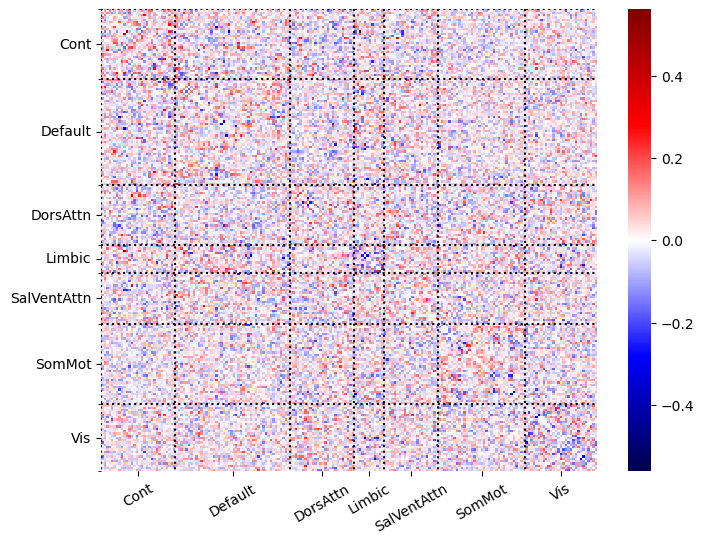

In [3]:
n_regions = matrices.shape[1]
plot_matrix(matrices[1], atlas)
plt.show()

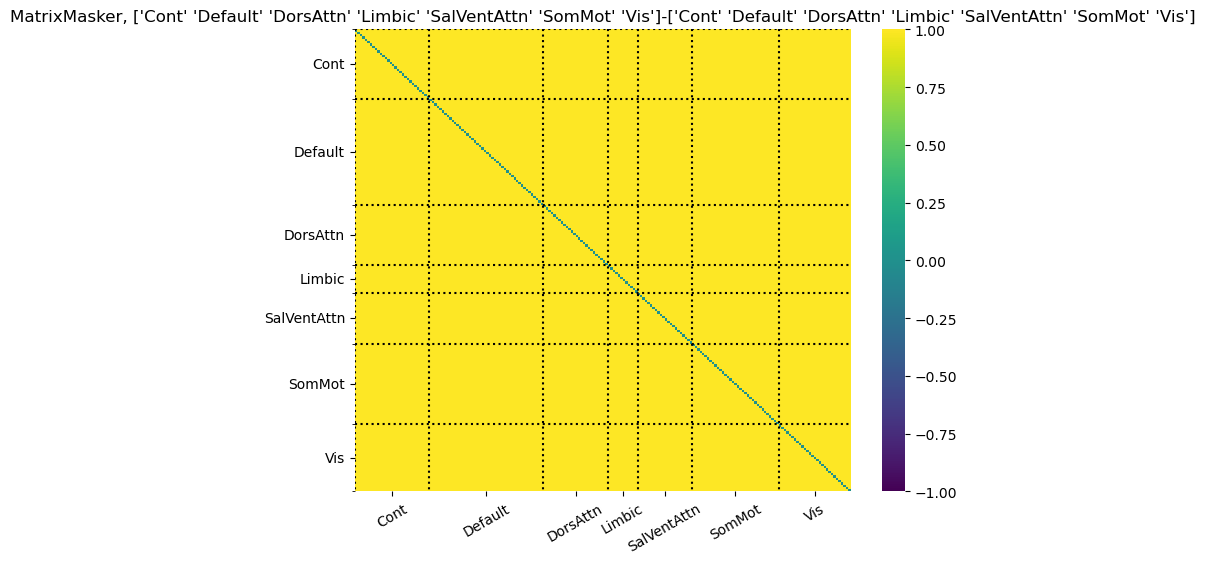

In [4]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

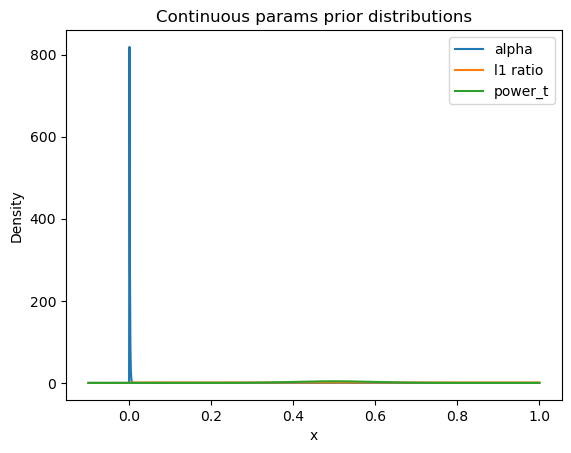

In [5]:
from scipy import stats

lambda_param = 1000
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)


plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [6]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from cogpred.supervised import macro_f1
from sklearn.neighbors import NearestNeighbors

In [7]:
y = metadata.cluster_label.values.astype(int)
#search.fit(matrices, y, groups=metadata.CEN_ANOM.values)
#cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
#cv_results

In [42]:
from sklearn.linear_model import ElasticNet
from nilearn.connectome import vec_to_sym_matrix
from cogpred.matrices import compute_mat_size
from numpy import linalg as npl
from scipy.linalg import inv

net = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    max_iter=2000,
    random_state=1999,
    class_weight="balanced"
)

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)

scores = []

cats = ("stable", "slow", "steep")
#maps = dict(zip(cats, ([], [], [])))
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

atlas = masker.atlas
n_features = masker.topology_.sum()
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
maps = []


# TODO Joblib that, I suppose there should be some very similar code in cross validate
# TODO Can we get the covariance matrix of predicted labels?
for train_idx, test_idx in outer_cv.split(matrices, y, groups=metadata.CEN_ANOM.values):
    X_train, y_train = matrices[train_idx], y[train_idx]
    X_test, y_test = matrices[test_idx], y[test_idx]
    clf.fit(X_train, y_train)

    scores.append(
        macro_f1(clf, X_test, y_test)
    )

    reg = clf.named_steps["classifier"]
    masker = clf.named_steps["matrixmasker"]

    # TODO Move to func?
    # We assume uncorrelated predictions, which is
    # not exactly true but anyway sigma_s_hat is not
    # invertible
    # Perform Haufe transform to make coefs interpretable
    
    # This is discarded due to numerical instabilities
    #s_hat = clf.predict_proba(X_test)# TODO predict from that?
    #msk = ~np.isnan(s_hat)
    #s_hat = s_hat[msk[:, 0], :]
    #sigma_s_hat = np.cov(s_hat.T)
    #sshinv = inv(sigma_s_hat) # Matrix inversion sucks

    # TODO Somehow weight by model performance
    X = masker.transform(matrices)
    sigma_X = np.cov(X.T)
    W = reg.coef_.T
    patterns = sigma_X @ W #@ sshinv 

    # We reconstruct the FC matrices associated
    # with Haufe's patterns
    # Patterns are of shape (n_features, n_classes)
    # There might be a way to reconstruct a matrix
    # of shape (n_regions, n_regions) without the loop
    
    arr = vec_to_sym_matrix(patterns.T, diagonal=np.zeros((3, n_regions)))
    maps.append(arr)
    
    #for i in range(k):
    #    arr = vec_to_sym_matrix(patterns[:, i], diagonal=np.zeros(n_regions))
    #    cat = cats[i]
    #    maps[cat].append(arr)
        
    

/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_base.py:372: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


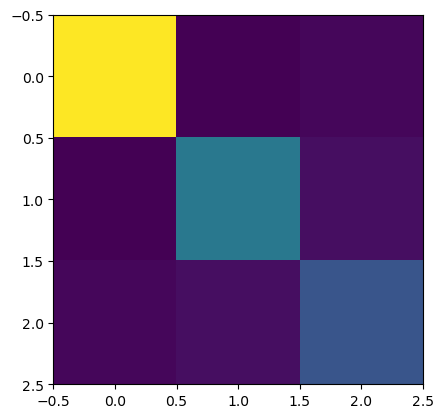

In [14]:
# Check the uncorrelated factors assumption
s_hat = clf.predict_proba(X_test)
msk = ~np.isnan(s_hat)
s_hat = s_hat[msk[:, 0], :]
sigma_s_hat = np.cov(s_hat.T)
plt.imshow(s_hat.T @ s_hat)
plt.show()

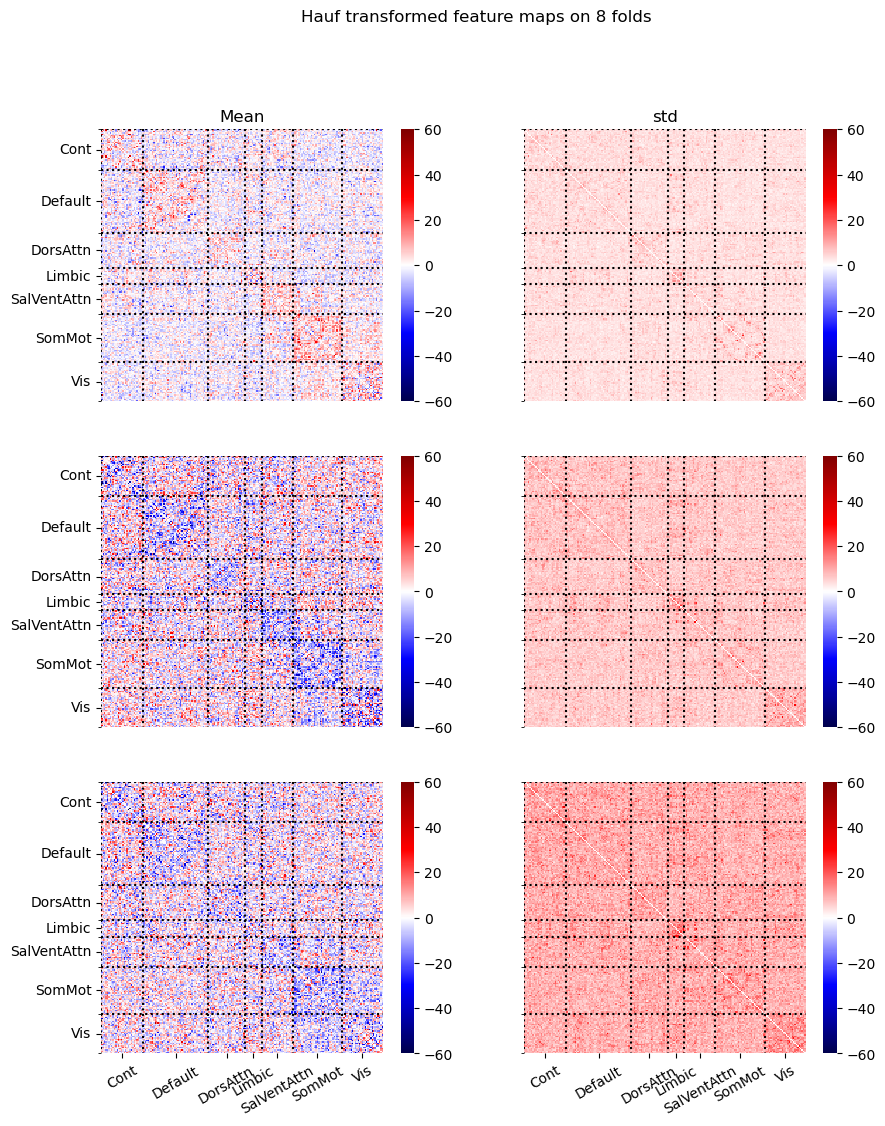

In [18]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


fig, axes = plt.subplots(3, 2, figsize=(10, 12))
for i, (cat, catmap) in enumerate(maps.items()):
    catmap = np.stack(catmap, axis=0)
    meanmap = np.mean(catmap, axis=0)
    stdmap = np.std(catmap, axis=0)

    plot_matrix(
        meanmap,
        disp_atlas,
        axes=axes[i, 0],
        bounds=(-60, 60),
        cmap="seismic",
    )
    plot_matrix(
        stdmap,
        disp_atlas,
        axes=axes[i, 1],
        bounds=(-60, 60),
        cmap="seismic",
    )
    axes[i, 1].set(yticklabels=[])
    axes[i, 1].tick_params(left=False)
    if i < 2:
        axes[i, 0].set(xticklabels=[])
        axes[i, 0].tick_params(bottom=False)
        axes[i, 1].set(xticklabels=[])
        axes[i, 1].tick_params(bottom=False)
        
    
axes[0, 0].set_title("Mean")
axes[0, 1].set_title("std")
fig.suptitle(f"Hauf transformed feature maps on {len(catmap)} folds")
plt.show()
# TODO Assume normality and threshold with t-tests? Since data is z transformed it should be ok

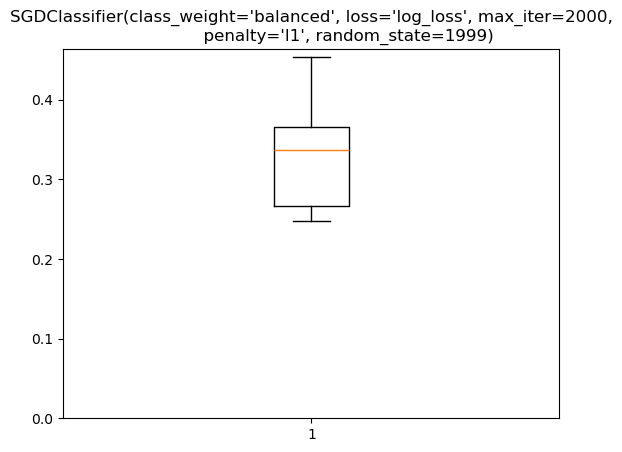

In [19]:
plt.boxplot(scores)
plt.ylim(0)
plt.title(reg)
plt.show()

In [ ]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-ncomponents-10_nregions-39_gsr-False_net-all/best_estimator.joblib']